In [21]:
import numpy as np

np.random.seed(1331)

m = 500  # genes
n = 1000  # cells
nb = 2  # batches

# 1. batch membership
X = np.zeros((n, nb))
batch = np.random.choice(nb, n, replace=True)
for b in range(1, nb + 1):
    X[batch == b, b - 1] = 1

# 2. batch effects
W_true = np.random.randn(m * nb).reshape(m, nb)
ln_delta = np.apply_along_axis(np.std, 1, W_true @ X.T)

# 3. true effects
K = 5
beta = np.random.gamma(1, 1, m * K).reshape(m, K)
theta = np.random.gamma(1, 1, n * K).reshape(n, K)
lambda_true = beta @ theta.T

ln_delta = ln_delta.reshape(1, -1)  # Broadcasting ln_delta to match lambda_true shape
lambda_vals = lambda_true * np.exp(ln_delta.T)
yy = np.apply_along_axis(lambda l: np.random.poisson(l, size=n), 1, lambda_vals)
oo = np.argsort(np.apply_along_axis(np.argmax, 0, theta.T))



In [22]:
df = pd.DataFrame(yy)
df.columns = ['c'+str(x) for x in df.columns]
df.index = ['g'+str(x) for x in df.index.values]
df

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c990,c991,c992,c993,c994,c995,c996,c997,c998,c999
g0,3,1,5,2,2,1,7,5,1,9,...,6,2,2,4,3,4,2,2,2,4
g1,4,8,7,12,4,1,3,4,6,1,...,11,5,12,9,6,8,2,2,3,5
g2,11,1,14,7,1,3,7,10,6,4,...,12,9,12,9,14,9,4,9,1,5
g3,9,6,15,16,1,2,13,10,6,7,...,27,15,19,11,13,16,7,17,5,13
g4,12,5,18,22,12,8,7,21,10,17,...,33,13,11,19,19,14,6,12,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g495,5,1,4,1,4,0,1,6,10,6,...,10,5,7,10,6,6,4,5,1,4
g496,12,2,7,8,1,4,7,5,4,1,...,11,4,6,7,6,3,2,9,0,5
g497,13,2,10,10,5,10,6,9,9,7,...,12,6,17,8,11,6,6,13,9,9
g498,7,10,12,5,0,1,4,7,1,5,...,12,7,7,7,15,4,3,9,7,2


In [23]:
import h5py as hf
import numpy as np
import scipy.sparse


smat = scipy.sparse.csc_matrix(df.to_numpy()) 
indptr = smat.indptr
indices = smat.indices
data = smat.data


sample='simdata'
f = hf.File(sample+'.h5','w')
grp = f.create_group(sample)
grp.create_dataset('barcodes',data=df.columns.values)

genes = [ 'g'+str(x) for x in df.index.values]
gene_names = [ 'g'+str(x) for x in df.index.values]

grp.create_dataset('genes',data=genes)
grp.create_dataset('gene_names',data=gene_names)
grp.create_dataset('indptr',data=smat.indptr)
grp.create_dataset('indices',data=smat.indices)
grp.create_dataset('data',data=smat.data,dtype=np.int32)

arr_shape = np.array([len(f[sample]['genes'][()]),len(f[sample]['barcodes'][()])])

grp.create_dataset('shape',data=arr_shape)
f.close()


In [24]:
pd.DataFrame(batch).to_csv('simdata_batchlabel.csv',index=False)

In [25]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics
from asap.annotation import ASAPNMF
import asapc
import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
from sklearn.preprocessing import StandardScaler
# import logging


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id


dl = DataSet(sample_in,sample_out)

dl.initialize_data()

df=pd.read_csv('/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata_batchlabel.csv')
# dl.add_batch_label([i.split('_')[1] for i in dl.barcodes])
dl.add_batch_label(df.x.values)

print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata


In [26]:
model = np.load(sample_out+'_dcnmf.npz')

In [27]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = ['gene_'+str(x) for x in range(len(dl.genes))]
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.barcodes

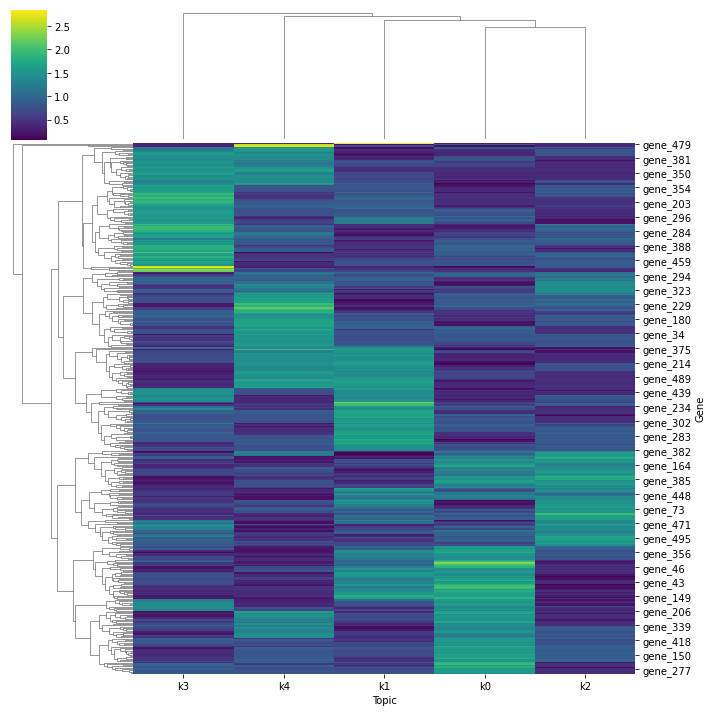

In [28]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [29]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = dl.barcodes
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=5, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.4,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,c0,4,-0.220982,10.753169
1,c1,4,5.161953,3.463211
2,c2,4,7.381594,12.854584
3,c3,1,4.679960,11.924621
4,c4,2,3.658737,4.365936
...,...,...,...,...
995,c995,3,7.756873,10.483581
996,c996,0,-0.614127,3.300913
997,c997,0,3.975211,0.643981
998,c998,2,1.735697,3.799653


Text(0, 0.5, 'UMAP2')

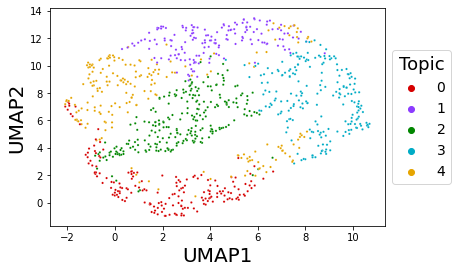

In [30]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

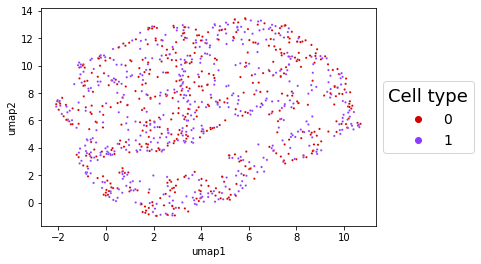

In [31]:
df_umap['batch'] = dl.batch_label
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [32]:
pbmodel = np.load(sample_out+'_pbulk.npz')